In [1]:
import pandas as pd
import numpy as np

# preprocessing & encoding
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# balancing
from imblearn.over_sampling import SMOTE

# feature-selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report
)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#mount googlw drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load inspect

In [4]:
file_path = '/content/drive/MyDrive/MYOWN_Colab Notebooks/personality_dataset.csv'
df = pd.read_csv(file_path)

#inspect
print("Shape:", df.shape)
display(df.head())
print("\n Info:")
print(df.info())
print("\n Missing values per column:")
print(df.isnull().sum())

Shape: (2900, 8)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert



 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

 Missing values per column:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality   

In [5]:
#basic cleaning
df=df.dropna()
print("After dropna, shape:", df.shape)

After dropna, shape: (2477, 8)


In [6]:
#encode category
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])
print("All columns are now numeric:\n", df.dtypes)


All columns are now numeric:
 Time_spent_Alone             float64
Stage_fear                     int64
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing      int64
Friends_circle_size          float64
Post_frequency               float64
Personality                    int64
dtype: object


# split feature & target,train/test,

In [7]:
target = "Personality"
X = df.drop(columns=target)
y = df[target]
print("Features shape:", X.shape, " Target distribution:\n", y.value_counts())


Features shape: (2477, 7)  Target distribution:
 Personality
0    1274
1    1203
Name: count, dtype: int64


In [8]:
#train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1733, 7) Test size: (744, 7)


# balance with smote,scale feature

In [37]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After  SMOTE:", y_res.value_counts().to_dict())

Before SMOTE: {0: 891, 1: 842}
After  SMOTE: {0: 891, 1: 891}


In [38]:
#scale ffeature
scaler = StandardScaler()
X_res_scaled  = pd.DataFrame(scaler.fit_transform(X_res), columns=X_res.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


# correlation

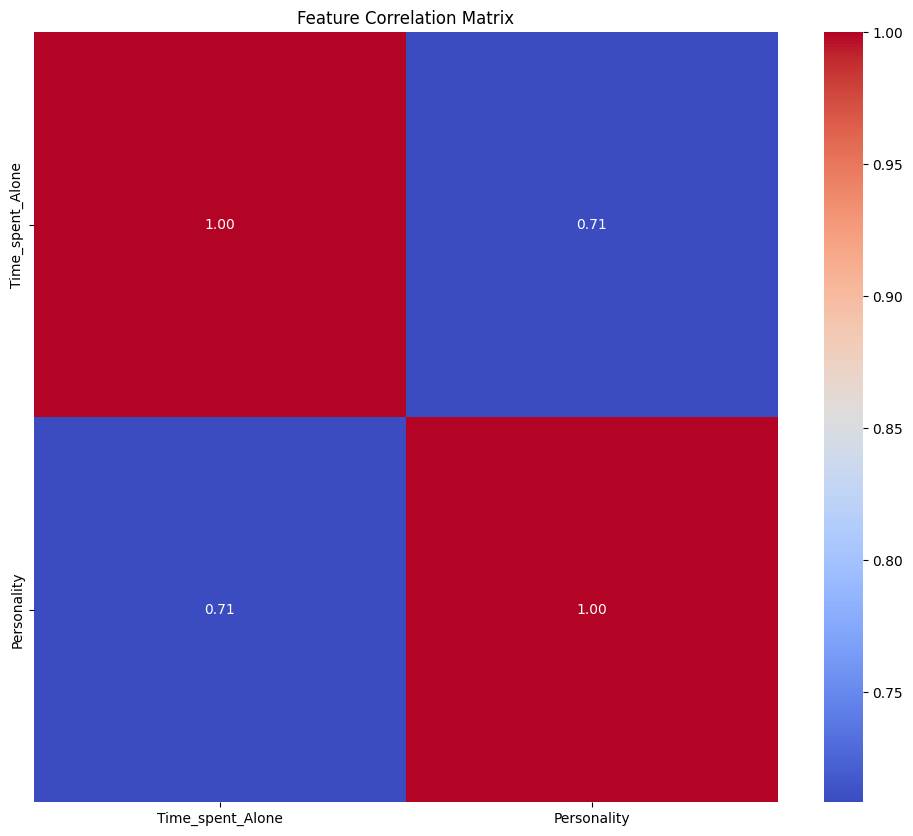

Dropped due to high corr: []


In [48]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.concat([X_res_scaled, y_res], axis=1).corr(),
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Auto-drop one of any pair with corr > 0.65
corr_matrix = X_res_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
print("Dropped due to high corr:", to_drop)

X_res_scaled.drop(columns=to_drop, inplace=True)
X_test_scaled.drop(columns=to_drop, inplace=True)


# lasso feature

In [49]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
selector = SelectFromModel(estimator=lasso)
selector.fit(X_res_scaled, y_res)

mask = selector.get_support()
selected = X_res_scaled.columns[mask].tolist()
print("Selected features:", selected)

X_train_sel = X_res_scaled[selected]
X_test_sel  = X_test_scaled[selected]

Selected features: ['Time_spent_Alone']


# train models

In [45]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree'      : DecisionTreeClassifier(random_state=42),
    'SVM'               : SVC(probability=True, random_state=42)
}

for name, mdl in models.items():
    mdl.fit(X_train_sel, y_res)
    print(f"{name} trained")


LogisticRegression trained
DecisionTree trained
SVM trained


# evaluate test

In [50]:
results = {}
for name, mdl in models.items():
    X_eval = X_test_sel
    y_pred = mdl.predict(X_eval)
    y_prob = mdl.predict_proba(X_eval)[:,1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# display summary table
pd.DataFrame(results).T



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       383
           1       0.89      0.82      0.85       361

    accuracy                           0.86       744
   macro avg       0.87      0.86      0.86       744
weighted avg       0.87      0.86      0.86       744


DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       383
           1       0.88      0.94      0.91       361

    accuracy                           0.91       744
   macro avg       0.91      0.91      0.91       744
weighted avg       0.91      0.91      0.91       744


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       383
           1       0.88      0.94      0.91       361

    accuracy                           0.91       744
   macro avg       0

,Accuracy,Precision,Recall,ROC-AUC
LogisticRegression,0.864247,0.891566,0.819945,0.899756
DecisionTree,0.911290,0.883117,0.941828,0.934256
SVM,0.911290,0.883117,0.941828,0.916254


In [51]:
#cross validation
cv_metrics = {}
scoring = ['accuracy','precision','recall','roc_auc']

for name, mdl in models.items():
    scores = {
        metric: cross_val_score(mdl, X_train_sel, y_res,
                                 cv=5, scoring=metric).mean()
        for metric in scoring
    }
    cv_metrics[name] = scores

pd.DataFrame(cv_metrics).T


,accuracy,precision,recall,roc_auc
LogisticRegression,0.869257,0.917567,0.812592,0.913556
DecisionTree,0.920883,0.910993,0.933815,0.933510
SVM,0.920883,0.910993,0.933815,0.921144
